# Part 3: Mixed Effects Models
<b>Author</b>: Sterling Cutler
<br>
<b>Date</b>: March 22, 2018

In the previous sections, we removed the claim number before fitting out data to the linear model. In doing so, we treated the dataset as a population when those select claims were truly a subset (sample) of the population. Fitting a model to a population of insurance data is most often infeasible and inefficient. Fitting a model to excessively large data can also lead to the problem of data dredging (or p-hacking), in which all the explanatory variables used in the model return significant when they often wouldn't be in practice.

When dealing with a variable that comes from a probability distribution, in which there are infinite possible values, we are dealing with a random variable. Random variables have their own impact on model residuals than fixed-effect variables, so it useful to use a model that can capture these differences. Mixed effects models allow us to model data with fixed and random variables. We could use a mixed model on our previous dataset and specify claim number as a random variable, but instead let's focus on a more practical demonstration of how an insurance analyst may look at certain locations.

In [1]:
# Load new dataset and inspect the data
library(insuranceData)

data(dataCar)
str(dataCar)
paste()
head(dataCar)

'data.frame':	67856 obs. of  11 variables:
 $ veh_value: num  1.06 1.03 3.26 4.14 0.72 2.01 1.6 1.47 0.52 0.38 ...
 $ exposure : num  0.304 0.649 0.569 0.318 0.649 ...
 $ clm      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ numclaims: int  0 0 0 0 0 0 0 0 0 0 ...
 $ claimcst0: num  0 0 0 0 0 0 0 0 0 0 ...
 $ veh_body : Factor w/ 13 levels "BUS","CONVT",..: 4 4 13 11 4 5 8 4 4 4 ...
 $ veh_age  : int  3 2 2 2 4 3 3 2 4 4 ...
 $ gender   : Factor w/ 2 levels "F","M": 1 1 1 1 1 2 2 2 1 1 ...
 $ area     : Factor w/ 6 levels "A","B","C","D",..: 3 1 5 4 3 3 1 2 1 2 ...
 $ agecat   : int  2 4 2 2 2 4 4 6 3 4 ...
 $ X_OBSTAT_: Factor w/ 1 level "01101    0    0    0": 1 1 1 1 1 1 1 1 1 1 ...


character(0)

veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,X_OBSTAT_
1.06,0.3039014,0,0,0,HBACK,3,F,C,2,01101 0 0 0
1.03,0.6488706,0,0,0,HBACK,2,F,A,4,01101 0 0 0
3.26,0.5694730,0,0,0,UTE,2,F,E,2,01101 0 0 0
4.14,0.3175907,0,0,0,STNWG,2,F,D,2,01101 0 0 0
0.72,0.6488706,0,0,0,HBACK,4,F,C,2,01101 0 0 0
2.01,0.8542094,0,0,0,HDTOP,3,M,C,4,01101 0 0 0


#### Variables of Interest
Our target variable will be claim amount (rounded to integer) and our random variable will be area. The assumption of this study is that the six possible area levels are only a sample of all the levels available in the population, which is often the case. The fixed-effect variables we'll focus on in this case are vehicle body, vehicle age, and driver's age.

In [2]:
# View stats/values of explantory variables
paste('Vehicle Value:')
summary(dataCar$veh_value)
paste()
paste('Vehicle Body:')
table(dataCar$veh_body)
paste()
paste('Vehicle Age:')
table(dataCar$veh_age)
paste()
paste('Driver Gender:')
table(dataCar$gender)
paste()
paste('Driver Age:')
table(dataCar$agecat)
paste()
paste('Area:')
table(dataCar$area)
paste()

[1] "Vehicle Value:"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.010   1.500   1.777   2.150  34.560 

character(0)

[1] "Vehicle Body:"


  BUS CONVT COUPE HBACK HDTOP MCARA MIBUS PANVN RDSTR SEDAN STNWG TRUCK   UTE 
   48    81   780 18915  1579   127   717   752    27 22233 16261  1750  4586 

character(0)

[1] "Vehicle Age:"


    1     2     3     4 
12257 16587 20064 18948 

character(0)

[1] "Driver Gender:"


    F     M 
38603 29253 

character(0)

[1] "Driver Age:"


    1     2     3     4     5     6 
 5742 12875 15767 16189 10736  6547 

character(0)

[1] "Area:"


    A     B     C     D     E     F 
16312 13341 20540  8173  5912  3578 

character(0)

[1] 51514    11

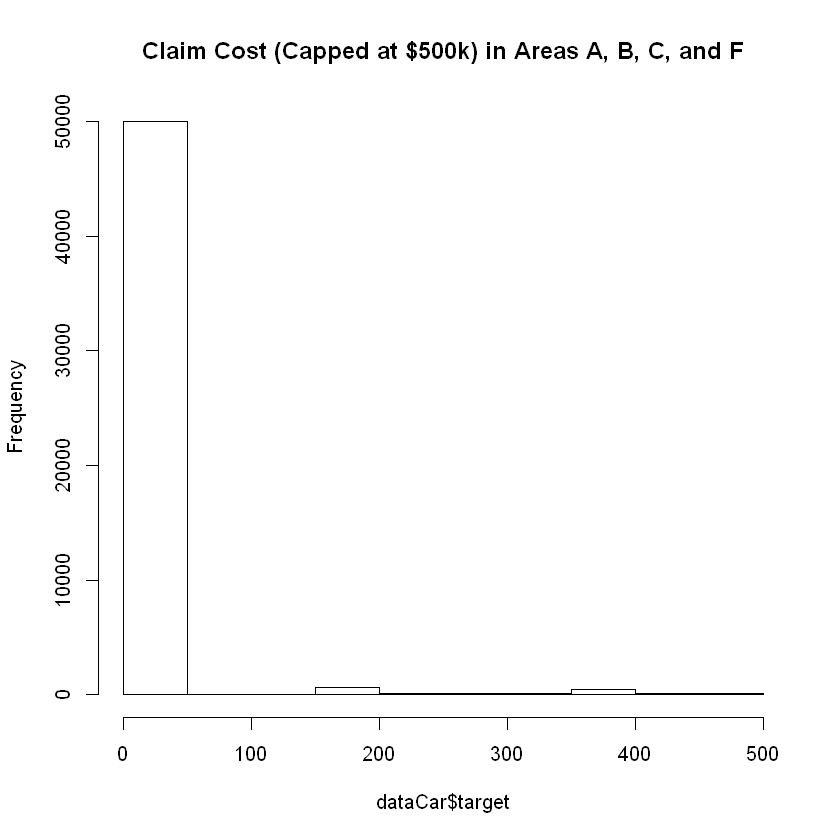

In [3]:
# Subset data to include claims under $500K and areas A, B, C, and F
dataCar <- subset(dataCar, claimcst0 < 500)
dataCar <- subset(dataCar, area %in% c("A", "B", "C", "F"))
dim(dataCar)

# View distribution of target variable
dataCar$target <- as.integer(dataCar$claimcst0)
hist(dataCar$target, main='Claim Cost (Capped at $500k) in Areas A, B, C, and F')

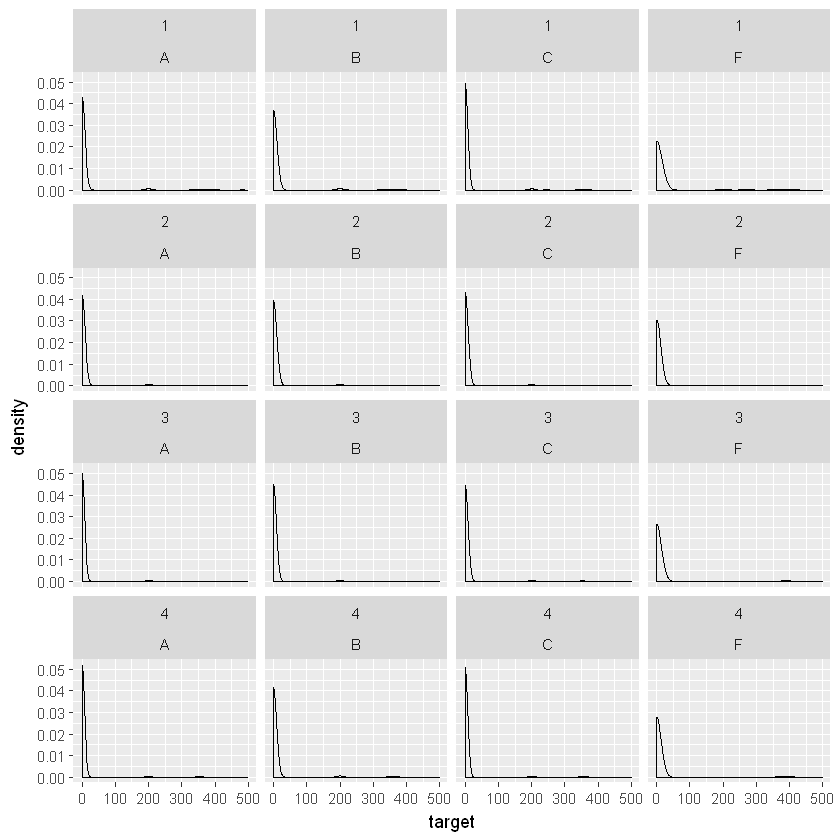

In [4]:
# Visualize claim cost by vehicle age and area
library(ggplot2)

ggplot(dataCar, aes(x = target)) + geom_density() + facet_wrap(as.factor(veh_age) ~ area)

#### Benchmark Model
We can see some target deviation between certain (vehicle_age, area) groupings. Let's start by fitting a simple GLM with no control for random effects.

In [5]:
glm_model <- glm(target ~ as.factor(veh_age), data=dataCar, family=poisson())

summary(glm_model)


Call:
glm(formula = target ~ as.factor(veh_age), family = poisson(), 
    data = dataCar)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-4.358  -4.104  -4.104  -3.892  56.092  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          2.121776   0.003600 589.438   <2e-16 ***
as.factor(veh_age)2  0.129004   0.004598  28.056   <2e-16 ***
as.factor(veh_age)3  0.008973   0.004563   1.967   0.0492 *  
as.factor(veh_age)4 -0.096865   0.004711 -20.561   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 3127209  on 51513  degrees of freedom
Residual deviance: 3124257  on 51510  degrees of freedom
AIC: 3135355

Number of Fisher Scoring iterations: 9


## Generalized Linear Mixed Effects Model (GLMM)

As we can see from the histogram above, our target variable does not have a normal distribution but rather a Poisson distribution. This is commonly seen in insurance for claim count and severity. If our target variable had a Gaussian distribution, we could use a linear mixed effects model (LME) or a Nonlinear Mixed Effect Model (NLME). 

However in the case of other exponential family distributions, we will consider the Generalized Mixed Effect Model (GLMM) which has the form: $y=X\beta + Z\mu + \epsilon$ where $X\beta$ represents the fixed-effects predictors variables and their regression coefficients and $Z\mu$ represents the random-effects variables and their complements to the regression coefficients. 

Because the GLMM does not have a closed-form solution, different methods of maximum likelihood estimation (MLE) are used to determine the model parameters. Here we will use Laplace approximation and control for area.

In [6]:
library(Matrix)
library(lme4)

glmm_model <- glmer(target ~ as.factor(veh_age) + (1|area), family="poisson", data=dataCar)

summary(glmm_model)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: target ~ as.factor(veh_age) + (1 | area)
   Data: dataCar

     AIC      BIC   logLik deviance df.resid 
 3132072  3132116 -1566031  3132062    51509 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
 -3.450  -2.997  -2.878  -2.758 181.202 

Random effects:
 Groups Name        Variance Std.Dev.
 area   (Intercept) 0.01392  0.118   
Number of obs: 51514, groups:  area, 4

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          2.168490   0.045591   47.56   <2e-16 ***
as.factor(veh_age)2  0.129465   0.004588   28.22   <2e-16 ***
as.factor(veh_age)3  0.005676   0.004551    1.25    0.212    
as.factor(veh_age)4 -0.100774   0.004701  -21.44   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) a.(_)2 a.(_)3
as.fctr(_)2 -0.038           

#### ToDo: Interpret Results
... explain lower AIC and deviance scores, change in p-values, effect of controlling random effects, etc.